In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import statsmodels as sm
from statsmodels.imputation import mice
from tqdm import tqdm
import geopandas as gpd


In [3]:
df = pd.DataFrame(np.random.randint(0,1000,size=(1000, 104)), columns=list('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'))
df = df.mask(np.random.random(df.shape) < .2)
df.shape

(1000, 104)

In [8]:
big_time = []
for k in tqdm(range(100,200000,10000)):
    df = pd.DataFrame(np.random.randint(0,k,size=(k, 52)), columns=list('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'))
    df = df.mask(np.random.random(df.shape) < .1)
    run_time = []
    #for i in range(3,df.columns.shape[0],10):
    start = time.time()
    imp=sm.imputation.mice.MICEData(df.iloc[:,:i],perturbation_method='gaussian', k_pmm=2)
    for j in range(10):
        imp.update_all()
    end = time.time()
    run_time.append(end-start)
    big_time.append(run_time)




  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


  5%|████▏                                                                              | 1/20 [00:21<06:45, 21.33s/it]


 10%|████████▎                                                                          | 2/20 [01:01<09:14, 30.83s/it]


 15%|████████████▍                                                                      | 3/20 [01:59<11:16, 39.78s/it]


 20%|████████████████▌                                                                  | 4/20 [03:01<12:06, 45.42s/it]


 25%|████████████████████▊                                                              | 5/20 [04:24<13:14, 52.99s/it]


 30%|████████████████████████▉                                                          | 6/20 [06:03<14:08, 60.63s/it]


 35%|█████████████████████████████                                                      | 7/20 [07:54<14:41, 67.83s/it]


 40%|████████████████

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

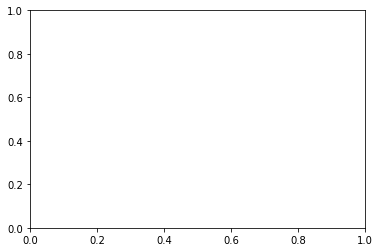

In [9]:
import seaborn as sns
sns.set_palette("PuBuGn_d")

for i in range(20):
    plt.plot(range(3,df.columns.shape[0],10), big_time[i], label=range(10,200000,10000)[i])
    


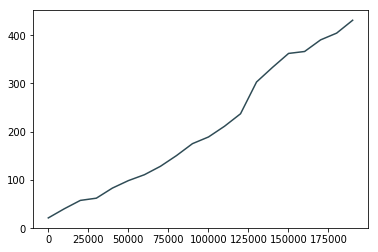

In [12]:
plt.plot(range(100,200000,10000), big_time)

In [2]:
imputed = gpd.read_file(r'J:\Geology\WSGS\Projects\Critical Minerals\hotspot analysis\max_nure_with_hucs_polygon.shp')
hucs = gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp')
hucs = hucs.to_crs(crs={'init': 'epsg:3732'})
hucs = imputed
hucs['FID'] = hucs.index.values


In [3]:
def GangsterRoll(element):
    Xbar = hucs[element].mean() #calculates the mean value of the element across all HUCS
    S = np.sqrt((((hucs[element])**2).sum()/len(hucs))-(Xbar**2)) #calculates the S value in the denominator
    import scipy.sparse as sp #import bruh
    mat = sp.dok_matrix((len(hucs), len(hucs)), dtype=np.int8) #creates a sparse matrix based on a dictionary of keys from above
    for huc_a, huc_b in neighbors.items(): #this creates a sparse matrix of spatial contiguity weights
        mat[huc_a, huc_b] = 1
        mat = mat.transpose().tocsr()
    z_score = []
    for i in tqdm(range(len(hucs))): #here is the G* function that calculates the z-score
        try:
            row_standardized = mat.toarray()[i]/mat.toarray()[i].sum()
            numerator = ((hucs[element].values*row_standardized).sum())-(row_standardized.sum()*Xbar) #numerator
            denominator = np.sqrt(abs(((row_standardized**2).sum())-(row_standardized.sum())**2)/(len(row_standardized)-1))*S #denominator
            z_score.append(numerator/denominator)
        except:
            z_score.append(np.nan)
    hucs['z_score'] = z_score
    hucs['z_score'].replace([np.inf, -np.inf], np.nan, inplace=True)
    hucs['z_score'].fillna(0, inplace=True)
    

In [6]:
run_time = []

for i in range(1,2382, 10):
    start = time.time()
    keys = hucs.loc[0:i].FID #huc basin number
    ds=[]
    for i in range(len(keys)):
        downstream = hucs[hucs['HUC_12'] == hucs.loc[i].HU_12_DS].FID.values
        ds.append(downstream)
    #huc basin downstream of huc basin
    us = []
    for i in range(len(keys)):
        upstream = hucs.loc[hucs['HU_12_DS'] == hucs.loc[i].HUC_12].FID.values
        us.append(upstream)
    lso = []
    for i in range(len(ds)):
        ls = []
        if ds[i].size>0:
            ls.append(ds[i][0])
        else:
            ls.append(-1)
        for j in range(len(us[i])):
            if us[i].size>0:
                ls.append(us[i][j])
            else:
                ls.append(-1)
        lso.append(ls)
    neighbors = dict(zip(keys, lso))
    GangsterRoll('au_ppm')
    end = time.time()
    run_time.append(end-start)


C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
  0%|                                                                                         | 0/2382 [00:00<?, ?it/s]C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
100%|█████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:17<00:00, 133.85it/s]


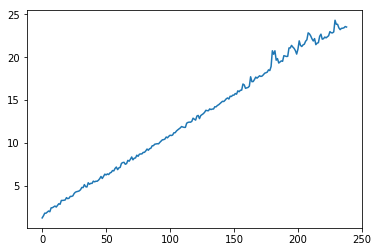

In [7]:
plt.plot(run_time)

In [17]:
import math


3.423591884497679